In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

from PIL import Image
from sklearn.preprocessing import StandardScaler



In [2]:
porosity_model = tf.keras.models.load_model('D:/Tomografia/All_Project/models/real_poro_model9962.h5')
permeability_model = tf.keras.models.load_model('D:\Tomografia\All_Project\models/real_perm_model9835.h5')
print('models loaded')

models loaded


In [3]:
#Create a function that make all the predictions having the model
#The images, and the logs.

def pred_properties(poro_model, perm_model, img_path, logs):
    pixel_imgs = []

    img = Image.open(img_path).convert('L')
    height = img.height
    while height!=logs.shape[0]:
        if logs.shape[0]>height:
            height +=1
        elif height>logs.shape[0]:
            height -=1

    img = img.resize((301,height), Image.ANTIALIAS)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.0

    for i in range(height):
        pixel_imgs.append(img[i])

    train_imgs_np = np.array(pixel_imgs)
    train_imgs_np = np.reshape(train_imgs_np, [-1, 1, 301, 1])

    standardScaler = StandardScaler()

    logs = pd.DataFrame(standardScaler.fit_transform(logs),
                      columns=logs.columns,
                      index= logs.index)

    poro_predicts = poro_model.predict([logs,train_imgs_np])
    perm_predicts = perm_model.predict([logs, train_imgs_np])

    i=0
    for index, row in df.iterrows():
        if row['Densidad']==-999.0:
            poro_predicts[i]=np.nan
            perm_predicts[i]=np.nan
        i+=1

    return poro_predicts, perm_predicts

In [4]:
df = pd.read_csv('D:/Tomografia/Set_2/all_logs2.csv', low_memory=False)
actual_data = pd.read_csv('D:/Tomografia/Set_2/datosbasicos.csv')
depth = actual_data['Profundidad']
actual_porosity = actual_data['Porosidad']
actual_permeability = actual_data['Permeabilidad']
df.describe()

,Profundidad,Densidad,PEF,Zeff,Porosidad,Permeabilidad
count,135119.000000,135119.000000,135119.000000,135119.000000,1763.000000,1763.000000
mean,2488.164404,-48.556990,-48.238415,-38.419716,0.221404,2678.960362
std,1899.865965,220.079152,220.155528,222.429311,0.081276,4418.568354
min,674.000000,-999.000000,-999.000000,-999.000000,0.075164,0.025110
25%,768.227239,2.294147,2.032912,12.178351,0.161531,8.646476
50%,838.852280,2.411438,2.458646,12.838866,0.250103,214.407642
75%,4579.083703,2.518301,2.939643,13.492171,0.291987,3333.348681
max,4648.130495,4.482751,19.954723,22.968033,0.366091,18157.475410


In [5]:
actual_data.describe()

,Profundidad,Porosidad,Permeabilidad
count,53.000000,53.000000,53.000000
mean,752.492453,0.233672,3237.277213
std,40.335582,0.078835,4771.165716
min,680.700000,0.078000,0.026100
25%,710.100000,0.172000,38.438100
50%,759.600000,0.266000,475.884400
75%,782.300000,0.297000,5782.528900
max,814.700000,0.352604,17477.451900


In [6]:
##Lets choice the first Core (T03/C01)
take = ['T002']
core = ['C003']

In [7]:
df = df[df['Core'].isin(core)]
df = df[df['Seccion'].isin(take)]
#df = df.drop(df[df['PEF']<0].index)
#df=df.replace(-999.0,np.nan)
df.describe()
#df.to_csv('D:\Tomografia\Pred properties\core3.csv')

,Profundidad,Densidad,PEF,Zeff,Porosidad,Permeabilidad
count,1491.000000,1491.000000,1491.000000,1491.000000,82.000000,82.000000
mean,738.527641,-56.251684,-56.596715,-47.206766,0.300781,4557.528444
std,0.882872,234.756457,234.670539,237.008780,0.012712,2461.506796
min,737.000000,-999.000000,-999.000000,-999.000000,0.276753,1929.425572
25%,737.763821,2.119871,1.763383,11.706568,0.291664,2156.894820
50%,738.527641,2.163000,1.785840,11.747792,0.299924,4504.181719
75%,739.291462,2.213709,1.818938,11.807873,0.311330,7000.941592
max,740.055282,2.282791,2.230488,12.496193,0.323279,7238.866821


In [8]:
#Get the numerical features
logs = df[['Densidad', 'PEF', 'Zeff']]

In [9]:
path = r'D:\Tomografia\Set_2\Corte_XZ_GE[2000-3800]\737.000-740.000.png'

poro_predicts, perm_predicts = pred_properties(porosity_model, permeability_model, path,logs)

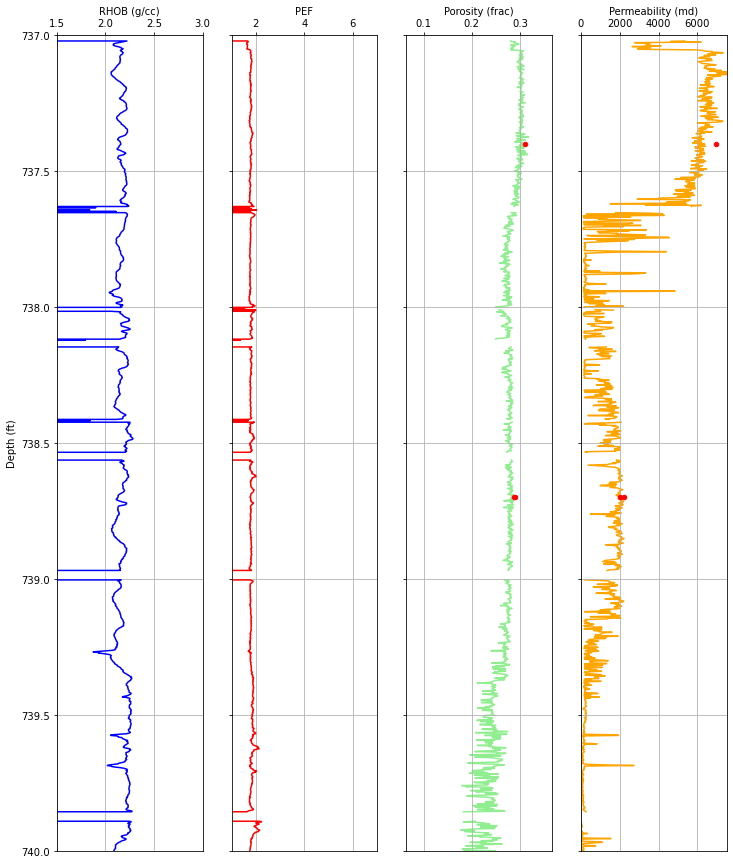

In [10]:
import matplotlib.image as mpimg

fig, axs  = plt.subplots(1,4, figsize=(12,15))
##Parameters que tendran todos los axes
for ax in axs:
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.grid(True)

###  RHOB ###
axs[0].set_ylabel('Depth (ft)')
axs[0].plot(df['Densidad'], df['Profundidad'], c='b')
axs[0].set_xlabel('RHOB (g/cc)')
axs[0].set_xlim((1.5,3))
axs[0].set_ylim((round(df['Profundidad'].min()),round(df['Profundidad'].max())))
axs[0].invert_yaxis()


### PEF ###
axs[1].plot(df['PEF'], df['Profundidad'], c='r')
axs[1].set_xlabel('PEF')
axs[1].set_xlim((1,7))
axs[1].set_ylim((round(df['Profundidad'].min()),round(df['Profundidad'].max())))
axs[1].invert_yaxis()
axs[1].set_yticklabels(labels=[])

### Porosidad ###
axs[2].plot(poro_predicts, df['Profundidad'], zorder=1, c='lightgreen')
axs[2].scatter(actual_data['Porosidad'], actual_data['Profundidad'],s=20, c='r', zorder=2)
axs[2].set_xlabel('Porosity (frac)')
axs[2].set_ylim((round(df['Profundidad'].min()),round(df['Profundidad'].max())))
axs[2].invert_yaxis()
axs[2].set_yticklabels(labels=[])

### Permeabilidad ###
axs[3].plot(perm_predicts, df['Profundidad'], zorder=1, c='orange')
axs[3].scatter(actual_data['Permeabilidad'], actual_data['Profundidad'], s=20, c='r', zorder=2)
axs[3].set_xlabel('Permeability (md)')
axs[3].set_xlim((0,7500))
axs[3].set_ylim((round(df['Profundidad'].min()),round(df['Profundidad'].max())))
axs[3].invert_yaxis()
axs[3].set_yticklabels(labels=[])

### Imagen
# axs[4].grid(False)
# img = mpimg.imread(path)
# axs[4].imshow(img)
# axs[4].set_xlim((0,img.shape[1]))
# axs[4].set_ylim((0,img.shape[0]))
# axs[4].invert_yaxis()
# axs[4].set_yticklabels(labels=[])
# axs[4].set_xticklabels(labels=[])

plt.savefig(r'D:\Tomografia\article\ImagesArticle\second_dataset_pred\C3T002.svg')
plt.show()

In [11]:
np_try = df['Profundidad'].to_numpy().reshape(-1, 1)
print(np_try)
print(poro_predicts)

[[737.       ]
 [737.0020505]
 [737.0041011]
 ...
 [740.0511811]
 [740.0532316]
 [740.0552822]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]


In [12]:
poro_df = pd.DataFrame({'Profundidad':np_try.flatten(), 'Porosidad':poro_predicts.flatten(), 'Permeabilidad':perm_predicts.flatten()})
poro_df.describe()

,Profundidad,Porosidad,Permeabilidad
count,1491.000000,1404.000000,1404.000000
mean,738.527641,0.271418,2019.517212
std,0.882872,0.024885,2261.454834
min,737.000000,0.177407,4.906695
25%,737.763821,0.265002,197.700867
50%,738.527641,0.276849,1277.287231
75%,739.291462,0.283701,2105.174805
max,740.055282,0.317942,8179.611328


In [13]:
poro_df.to_csv('D:\Tomografia\Pred properties\propertiesc1t1.csv')

In [13]:
actual_data = pd.read_csv('D:/Tomografia/Set_2/datosbasicos.csv')
depth = actual_data['Profundidad']
actual_porosity = actual_data['Porosidad']
actual_permeability = actual_data['Permeabilidad']
